In [65]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import truncnorm, norm
import trueskill
import pandas as pd
from statsbombpy import sb
import time


# Define parameters

In [66]:
mu_1 = 25  # Prior mean of player 1 skill
sigma_1 = 25/3  # Prior std dev of player 1 skill
mu_2 = 25  # Prior mean of player 2 skill
sigma_2 = 25/3  # Prior std dev of player 2 skill
sigma_t = 1  # Standard deviation of the match outcome

# Question 4: A first Gibbs sampler

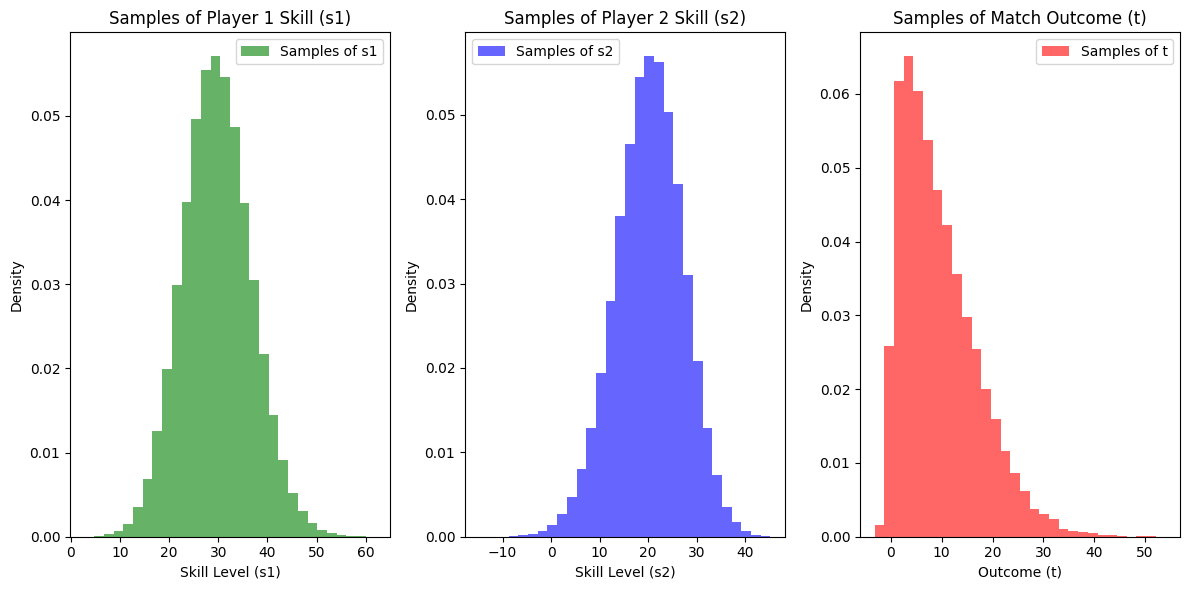

In [67]:
# Function to sample t given s1 and s2
def sample_t(s1, s2, sigma_t):
    return np.random.normal(s1 - s2, sigma_t)

# Function to sample s = [s1, s2] given t using joint normal
def sample_s_given_t(t, mu_1, mu_2, sigma_1, sigma_2):
    # Compute the conditional means and variances
    variance_s1 = sigma_1**2
    variance_s2 = sigma_2**2

    # Define A matrix and b vector
    A = np.array([[1, -1]])  # For the linear combination t = s1 - s2
    Sigma_s = np.array([[variance_s1, 0], [0, variance_s2]])  # Covariance matrix for s1 and s2
    b = np.array([t])

    # Conditional distribution of s given t
    inv_sigma_t = 1 / (sigma_t**2)  # Inverse of scalar sigma_t^2
    cov_s_given_t = np.linalg.inv(A.T @ A * inv_sigma_t + np.linalg.inv(Sigma_s))
    mean_s_given_t = cov_s_given_t @ (A.T * inv_sigma_t @ b + np.linalg.inv(Sigma_s) @ np.array([mu_1, mu_2]))

    # Draw a sample from the conditional distribution
    return np.random.multivariate_normal(mean_s_given_t, cov_s_given_t)

# Gibbs Sampling with Burn-in
def gibbs_sampling(num_samples, burn_in, initial_s1, initial_s2):
    s1_samples = [initial_s1]
    s2_samples = [initial_s2]
    t_samples = []

    # Iterate to generate samples
    for _ in range(num_samples):
        # Sample t given s1 and s2
        s1_current = s1_samples[-1]
        s2_current = s2_samples[-1]
        t_new = sample_t(s1_current, s2_current, sigma_t)
        t_samples.append(t_new)

        # Sample s = [s1, s2] given t, with rejection if s1 <= s2
        while True:
            s_new = sample_s_given_t(t_new, mu_1, mu_2, sigma_1, sigma_2)
            if s_new[0] > s_new[1]:  # Ensure s1 > s2
                s1_samples.append(s_new[0])
                s2_samples.append(s_new[1])
                break

    # Discard the burn-in samples
    return s1_samples[burn_in:], s2_samples[burn_in:], t_samples[burn_in:]

# Parameters for Gibbs sampling
num_samples = 100000
burn_in = 10000  # Number of samples to discard
initial_s1 = 26
initial_s2 = 24

# Perform Gibbs sampling
s1_samples, s2_samples, t_samples = gibbs_sampling(num_samples, burn_in, initial_s1, initial_s2)

# Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.hist(s1_samples, bins=30, density=True, alpha=0.6, color='g', label='Samples of s1')
plt.title('Samples of Player 1 Skill (s1)')
plt.xlabel('Skill Level (s1)')
plt.ylabel('Density')
plt.legend()

plt.subplot(1, 3, 2)
plt.hist(s2_samples, bins=30, density=True, alpha=0.6, color='b', label='Samples of s2')
plt.title('Samples of Player 2 Skill (s2)')
plt.xlabel('Skill Level (s2)')
plt.ylabel('Density')
plt.legend()

plt.subplot(1, 3, 3)
plt.hist(t_samples, bins=30, density=True, alpha=0.6, color='r', label='Samples of t')
plt.title('Samples of Match Outcome (t)')
plt.xlabel('Outcome (t)')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()


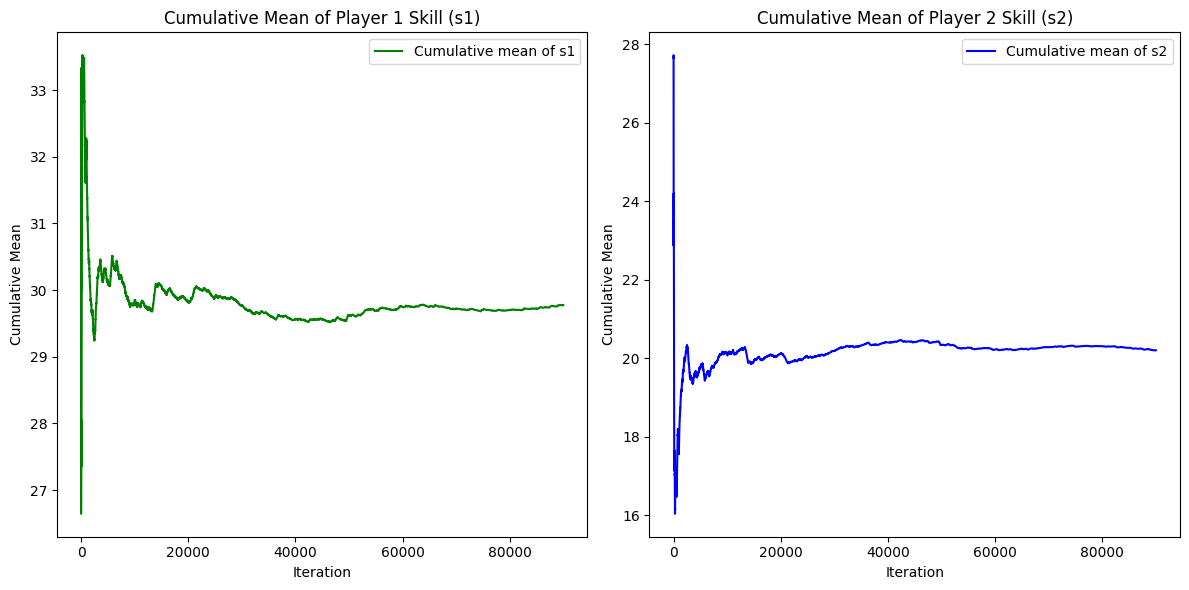

In [68]:
# Calculating cumulative means
s1_cumulative_mean = np.cumsum(s1_samples) / np.arange(1, len(s1_samples) + 1)
s2_cumulative_mean = np.cumsum(s2_samples) / np.arange(1, len(s2_samples) + 1)

# Plotting the cumulative mean for Player 1 Skill (s1) and Player 2 Skill (s2)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(s1_cumulative_mean, label='Cumulative mean of s1', color='g')
plt.title('Cumulative Mean of Player 1 Skill (s1)')
plt.xlabel('Iteration')
plt.ylabel('Cumulative Mean')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(s2_cumulative_mean, label='Cumulative mean of s2', color='b')
plt.title('Cumulative Mean of Player 2 Skill (s2)')
plt.xlabel('Iteration')
plt.ylabel('Cumulative Mean')
plt.legend()

plt.tight_layout()
plt.show()

<ipython-input-69-0cf12827a64d>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(s1_samples, label="Posterior of s1", shade=True)
<ipython-input-69-0cf12827a64d>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(s2_samples, label="Posterior of s2", shade=True)


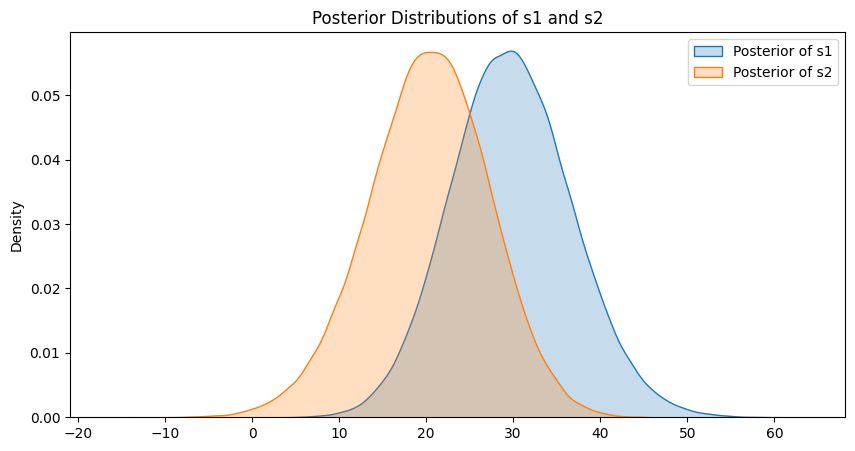

In [69]:
# Plot posterior distributions of s1 and s2
plt.figure(figsize=(10, 5))
sns.kdeplot(s1_samples, label="Posterior of s1", shade=True)
sns.kdeplot(s2_samples, label="Posterior of s2", shade=True)

plt.legend()
plt.title("Posterior Distributions of s1 and s2")
plt.show()


<ipython-input-70-251eca59816a>:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(s1_samples, label="Posterior of s1", shade=True)
<ipython-input-70-251eca59816a>:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(s2_samples, label="Posterior of s2", shade=True)


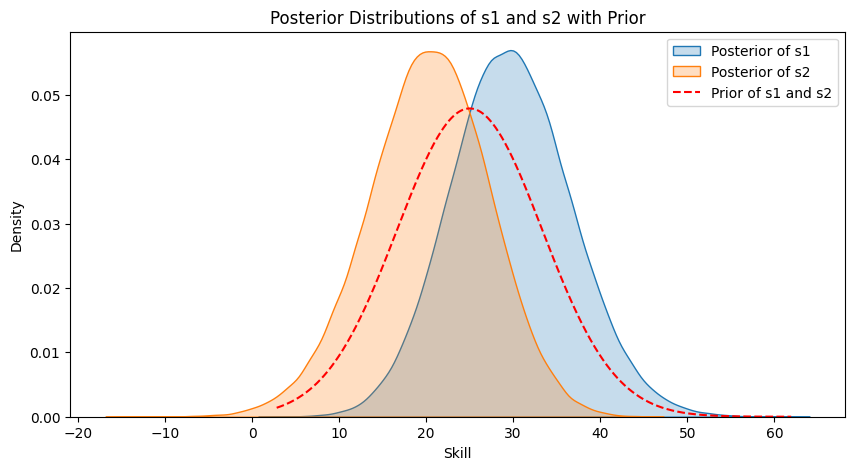

In [70]:


# Assuming s1_samples and s2_samples are already defined
# If not, you'll need to load/generate these samples first.

# Parameters for the normal distribution of player 1
mu_1 = 25  # Prior mean of player 1 skill
sigma_1 = 25/3  # Prior std dev of player 1 skill

# Generate values for the normal distribution of s1
x_values = np.linspace(min(s1_samples), max(s1_samples), 1000)
prior_s1 = norm.pdf(x_values, mu_1, sigma_1)

# Plot posterior distributions of s1 and s2
plt.figure(figsize=(10, 5))
sns.kdeplot(s1_samples, label="Posterior of s1", shade=True)
sns.kdeplot(s2_samples, label="Posterior of s2", shade=True)

# Plot the prior distribution of s1 (normal distribution)
plt.plot(x_values, prior_s1, label="Prior of s1 and s2", linestyle='--', color='red')

# Customize the plot
plt.legend()
plt.title("Posterior Distributions of s1 and s2 with Prior")
plt.xlabel("Skill")
plt.ylabel("Density")

# Show the plot
plt.show()


100
2.078638792037964
[29.51276192 20.25792521] [[41.40556516 26.14687069]
 [26.14687069 43.2125716 ]]
200
2.011507272720337
[29.10169227 21.00942734] [[43.58954862 27.41995962]
 [27.41995962 45.2461926 ]]
500
4.260528802871704
[29.96555793 19.84306402] [[48.00041981 22.80199384]
 [22.80199384 46.25628396]]
1000
9.265438795089722
[29.65776534 20.49850533] [[49.05592205 24.02251575]
 [24.02251575 46.96033769]]
5000
21.925771951675415
[30.05612677 20.01194196] [[47.94781476 20.71653787]
 [20.71653787 47.81260012]]
10000
27.804282188415527
[29.56905399 20.44948599] [[46.90892094 22.61829149]
 [22.61829149 46.6900412 ]]


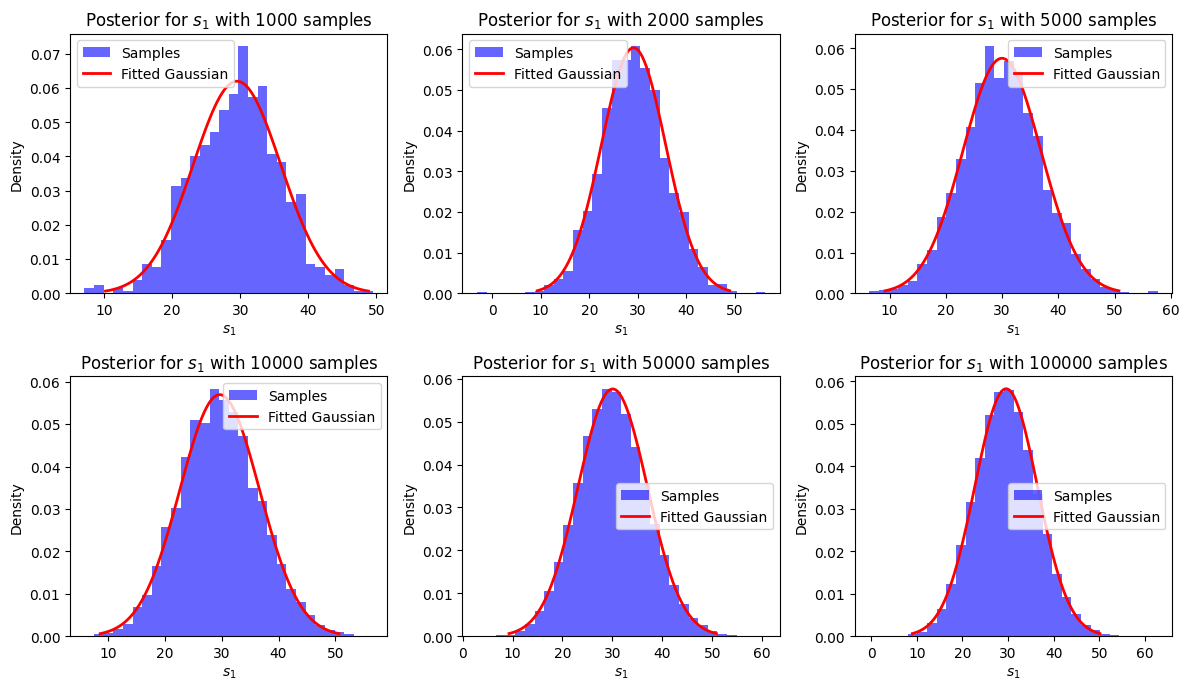

In [71]:
def fit_gaussian(samples):
    mean = np.mean(samples, axis=0)
    covariance = np.cov(samples, rowvar=False)
    return mean, covariance

def compare_samples(sample_sizes):


    plt.figure(figsize=(12, 10))

    for i, size in enumerate(sample_sizes):

        timee = time.time()

        burn_in = int(size * 0.1)  # 10% of sample size
        print(burn_in)

        sample1, sample2, sample_t = gibbs_sampling(num_samples=size, burn_in=burn_in, initial_s1=25, initial_s2=25)

        print(time.time() - timee)

        samples = np.array([list(i) for i in zip(sample1, sample2)])

        mean, covariance = fit_gaussian(samples)

        print(mean, covariance)

        plt.subplot(3, 3, i+1)
        plt.hist(samples[:, 0], bins=30, density=True, alpha=0.6, color='b', label='Samples')
        x = np.linspace(mean[0] - 3*np.sqrt(covariance[0, 0]), mean[0] + 3*np.sqrt(covariance[0, 0]), 100)
        plt.plot(x, norm.pdf(x, mean[0], np.sqrt(covariance[0, 0])), 'r', lw=2, label='Fitted Gaussian')
        plt.title(f'Posterior for $s_1$ with {size} samples')
        plt.xlabel('$s_1$')
        plt.ylabel('Density')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Define sample sizes and burn-in
sample_sizes = [1000, 2000, 5000, 10000, 50000, 100000]

# Compare samples
compare_samples(sample_sizes)

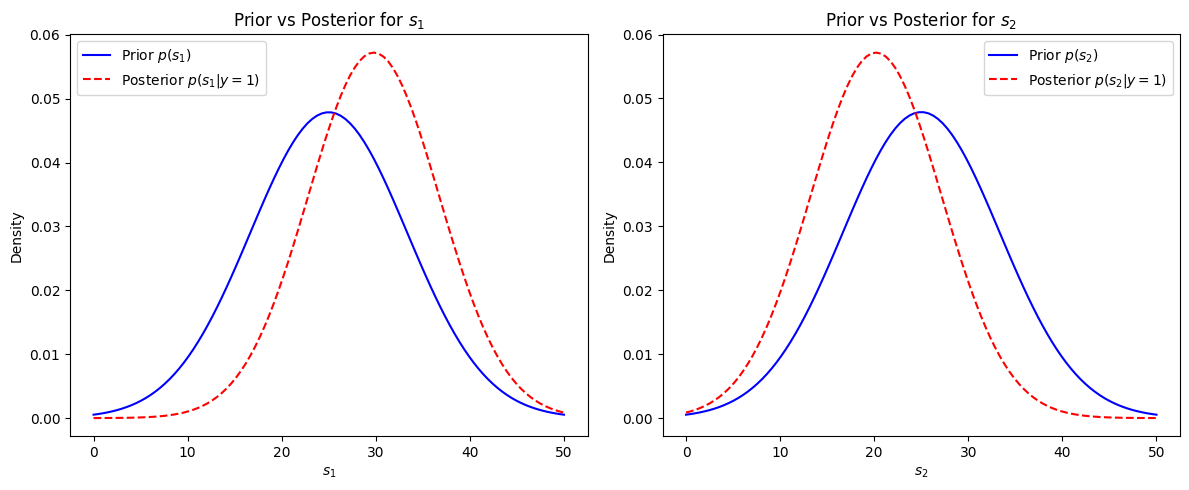

In [72]:
def plot_prior_vs_posterior(prior_mean, prior_std, posterior_mean, posterior_std):
    x = np.linspace(0, 50, 100)

    # Prior for s1 and s2
    prior_s1 = norm.pdf(x, prior_mean, prior_std)
    prior_s2 = norm.pdf(x, prior_mean, prior_std)

    plt.figure(figsize=(12, 5))

    # Prior vs Posterior for s1
    plt.subplot(1, 2, 1)
    plt.plot(x, prior_s1, 'b-', label='Prior $p(s_1)$')
    plt.plot(x, norm.pdf(x, posterior_mean[0], posterior_std[0]), 'r--', label='Posterior $p(s_1 | y=1)$')
    plt.title('Prior vs Posterior for $s_1$')
    plt.xlabel('$s_1$')
    plt.ylabel('Density')
    plt.legend()

    # Prior vs Posterior for s2
    plt.subplot(1, 2, 2)
    plt.plot(x, prior_s2, 'b-', label='Prior $p(s_2)$')
    plt.plot(x, norm.pdf(x, posterior_mean[1], posterior_std[1]), 'r--', label='Posterior $p(s_2 | y=1)$')
    plt.title('Prior vs Posterior for $s_2$')
    plt.xlabel('$s_2$')
    plt.ylabel('Density')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Define prior mean and standard deviation
posterior_mean = [np.mean(s1_samples), np.mean(s2_samples)]
posterior_std = [np.std(s1_samples), np.std(s2_samples)]

# Compare prior and posterior
plot_prior_vs_posterior(25, 25/3, posterior_mean=posterior_mean, posterior_std=posterior_std)


# Question 5: Assumed Density Filtering

#### Using truncated normal

In [73]:
# Sample data for Serie A matches (replace this with the full dataset)
data = pd.read_csv('SerieA.csv')

shuffle = False

if shuffle:
    # Shuffle the order of the DataFrame
    shuffled_data = data.sample(frac=1, random_state=1).reset_index(drop=True)
    data = shuffled_data

# Initialize parameters
initial_mean_skill = 25.0  # Initial mean skill for each team
initial_variance = (25.0 / 3)**2  # Initial variance for each team's skill
sigma_t = 1.0  # Standard deviation for match outcomes

# Initialize skills for each team
teams = set(data['team1']).union(set(data['team2']))
skills = {team: [initial_mean_skill, np.sqrt(initial_variance)] for team in teams}

# Function to sample t given s1 and s2
def sample_t(s1, s2, sigma_t):
    return np.random.normal(s1 - s2, sigma_t)

# Truncated Gaussian helper function for sampling with truncation
def truncated_gaussian(mean, std, lower_bound, upper_bound):
    a, b = (lower_bound - mean) / std, (upper_bound - mean) / std
    return truncnorm.rvs(a, b, loc=mean, scale=std)

# Function to sample s = [s1, s2] given t using truncated normal
def sample_s_given_t(t, mu_1, mu_2, sigma_1, sigma_2, sigma_t):
    variance_s1 = sigma_1**2
    variance_s2 = sigma_2**2

    # Precompute components for efficiency
    A = np.array([[1, -1]])
    Sigma_s_inv = np.array([[1 / variance_s1, 0], [0, 1 / variance_s2]])

    inv_sigma_t = 1 / (sigma_t**2)
    cov_s_given_t = np.linalg.inv(A.T @ A * inv_sigma_t + Sigma_s_inv)

    # Ensure the mean vector is one-dimensional
    mean_s_given_t = cov_s_given_t @ (A.T * inv_sigma_t * t + Sigma_s_inv @ np.array([[mu_1], [mu_2]]))
    mean_s_given_t = mean_s_given_t.flatten()

    # Draw samples from the truncated normal distribution for s1 > s2
    s_diff_mean = mean_s_given_t[0] - mean_s_given_t[1]
    s_diff_std = np.sqrt(cov_s_given_t[0, 0] + cov_s_given_t[1, 1] - 2 * cov_s_given_t[0, 1])

    # Truncate so that s1 - s2 > 0
    s_diff = truncated_gaussian(s_diff_mean, s_diff_std, 0, np.inf)

    # Sample s2 and compute s1 = s2 + s_diff
    s2 = np.random.normal(mean_s_given_t[1], np.sqrt(cov_s_given_t[1, 1]))
    s1 = s2 + s_diff

    return [s1, s2]

# Gibbs Sampling with Burn-in
def gibbs_sampling(num_samples, burn_in, initial_s1, initial_s2):
    s1_samples = np.zeros(num_samples)
    s2_samples = np.zeros(num_samples)

    # Initialize first samples
    s1_samples[0] = initial_s1[0]
    s2_samples[0] = initial_s2[0]

    for i in range(1, num_samples):
        s1_current = s1_samples[i - 1]
        s2_current = s2_samples[i - 1]

        t_new = sample_t(s1_current, s2_current, sigma_t)

        # Sample s given t using truncated Gaussian
        s_new = sample_s_given_t(t_new, initial_s1[0], initial_s2[0], initial_s1[1], initial_s2[1], sigma_t)
        s1_samples[i] = s_new[0]
        s2_samples[i] = s_new[1]

    return s1_samples[burn_in:], s2_samples[burn_in:]

# Parameters for Gibbs sampling
num_samples = 10000
burn_in = 500  # Number of samples to discard


for idx, row in data.iterrows():
    team1, team2 = row['team1'], row['team2']
    score1, score2 = row['score1'], row['score2']

    # Skip draws
    if score1 == score2:
        continue

    # Get initial skills for teams
    s1_initial = skills[team1]
    s2_initial = skills[team2]

    # Perform Gibbs sampling
    if score1 > score2:
        s1_samples, s2_samples = gibbs_sampling(num_samples, burn_in, s1_initial, s2_initial)
    else:
        s2_samples, s1_samples = gibbs_sampling(num_samples, burn_in, s2_initial, s1_initial)

    skills[team1] = [np.mean(s1_samples), np.std(s1_samples)]
    skills[team2] = [np.mean(s2_samples), np.std(s2_samples)]

    # Calculating cumulative means
    s1_cumulative_mean = np.cumsum(s1_samples) / np.arange(1, len(s1_samples) + 1)
    s2_cumulative_mean = np.cumsum(s2_samples) / np.arange(1, len(s2_samples) + 1)

    print(f"Initial skills for {team1}: Mean = {s1_initial[0]}, Standard Deviation  = {s1_initial[1]}")
    print(f"Initial skills for {team2}: Mean = {s2_initial[0]},  Standard Deviation = {s2_initial[1]}")
    print(f"Updated skills for {team1}: Mean = {skills[team1][0]},  Standard Deviation = {skills[team1][1]}")
    print(f"Updated skills for {team2}: Mean = {skills[team2][0]},  Standard Deviation = {skills[team2][1]}")
    print()




Initial skills for Chievo: Mean = 25.0, Standard Deviation  = 8.333333333333334
Initial skills for Juventus: Mean = 25.0,  Standard Deviation = 8.333333333333334
Updated skills for Chievo: Mean = 20.43593689465617,  Standard Deviation = 6.812401502693454
Updated skills for Juventus: Mean = 29.42842169583574,  Standard Deviation = 6.88465760495247

Initial skills for Lazio: Mean = 25.0, Standard Deviation  = 8.333333333333334
Initial skills for Napoli: Mean = 25.0,  Standard Deviation = 8.333333333333334
Updated skills for Lazio: Mean = 20.036646284440558,  Standard Deviation = 6.995447098416138
Updated skills for Napoli: Mean = 30.068598083510672,  Standard Deviation = 7.033906107680614

Initial skills for Torino: Mean = 25.0, Standard Deviation  = 8.333333333333334
Initial skills for Roma: Mean = 25.0,  Standard Deviation = 8.333333333333334
Updated skills for Torino: Mean = 20.555818859451055,  Standard Deviation = 6.903643386050788
Updated skills for Roma: Mean = 29.7024566891421,  

In [74]:
skills

{'Inter': [29.16504060968376, 1.1998324744563889],
 'Empoli': [27.953198197985067, 1.1296895223943606],
 'Lazio': [27.29704789556244, 0.9745404165686847],
 'Parma': [25.397545673565467, 1.0124234599987803],
 'Roma': [29.482303244950337, 1.5430443565595229],
 'Napoli': [28.66346916104596, 1.150376575158852],
 'Cagliari': [26.59057404642478, 0.9237204399441614],
 'Juventus': [26.007635053838577, 1.0866361438844763],
 'Sassuolo': [25.716009650587914, 1.1046500559762804],
 'Chievo': [26.21310976517887, 0.9900188854617072],
 'Milan': [29.035736826416226, 1.3547798745426125],
 'Sampdoria': [26.826198887492968, 1.107431487881122],
 'Torino': [28.56940590687978, 1.148577439536856],
 'Frosinone': [25.570433280145387, 0.9208633987156338],
 'Atalanta': [30.098098300262276, 1.7997074312672807],
 'Udinese': [28.525143628210955, 1.2095919754845987],
 'Genoa': [24.941203432647566, 1.1333671678140875],
 'Fiorentina': [24.205631492577446, 0.8540543306748379],
 'Spal': [27.104406183612728, 1.01121758885

In [75]:
# Sort the dictionary by the first element of each value list
sorted_data = dict(sorted(skills.items(), key=lambda x: x[1][0], reverse=True))

# Print the sorted dictionary
for team, values in sorted_data.items():
    print(f"{team}: {round(values[0],2)} , {round(values[1],2)}")

Atalanta: 30.1 , 1.8
Bologna: 29.55 , 1.21
Roma: 29.48 , 1.54
Inter: 29.17 , 1.2
Milan: 29.04 , 1.35
Napoli: 28.66 , 1.15
Torino: 28.57 , 1.15
Udinese: 28.53 , 1.21
Empoli: 27.95 , 1.13
Lazio: 27.3 , 0.97
Spal: 27.1 , 1.01
Sampdoria: 26.83 , 1.11
Cagliari: 26.59 , 0.92
Chievo: 26.21 , 0.99
Juventus: 26.01 , 1.09
Sassuolo: 25.72 , 1.1
Frosinone: 25.57 , 0.92
Parma: 25.4 , 1.01
Genoa: 24.94 , 1.13
Fiorentina: 24.21 , 0.85


# Question 6: Using the model for predictions

### We will use the Monte Carlo method to predict the next step ahead

In [76]:
# Return +1 if player 1 wins and -1 if player 2 wins
data = pd.read_csv("SerieA.csv")
print(data.head())

   yyyy-mm-dd  HH:MM     team1     team2  score1  score2
0  2018-08-18  18:00    Chievo  Juventus       2       3
1  2018-08-18  20:30     Lazio    Napoli       1       2
2  2018-08-19  18:00    Torino      Roma       0       1
3  2018-08-19  20:30  Sassuolo     Inter       1       0
4  2018-08-19  20:30     Parma   Udinese       2       2


### Initialize variables

In [77]:
# Initialize TrueSkill environment with zero draw probability
env = trueskill.TrueSkill(draw_probability=0)

# Dictionary to store ratings for each team
ratings = {}


In [78]:
# Get the list of unique teams
teams = pd.unique(data[['team1', 'team2']].values.ravel())

print(teams)

['Chievo' 'Juventus' 'Lazio' 'Napoli' 'Torino' 'Roma' 'Sassuolo' 'Inter'
 'Parma' 'Udinese' 'Empoli' 'Cagliari' 'Bologna' 'Spal' 'Atalanta'
 'Frosinone' 'Milan' 'Sampdoria' 'Genoa' 'Fiorentina']


In [79]:
# Initialize each team's rating
for team in teams:
    ratings[team] = env.create_rating()

ratings # Each team starts with equal rating

{'Chievo': trueskill.Rating(mu=25.000, sigma=8.333),
 'Juventus': trueskill.Rating(mu=25.000, sigma=8.333),
 'Lazio': trueskill.Rating(mu=25.000, sigma=8.333),
 'Napoli': trueskill.Rating(mu=25.000, sigma=8.333),
 'Torino': trueskill.Rating(mu=25.000, sigma=8.333),
 'Roma': trueskill.Rating(mu=25.000, sigma=8.333),
 'Sassuolo': trueskill.Rating(mu=25.000, sigma=8.333),
 'Inter': trueskill.Rating(mu=25.000, sigma=8.333),
 'Parma': trueskill.Rating(mu=25.000, sigma=8.333),
 'Udinese': trueskill.Rating(mu=25.000, sigma=8.333),
 'Empoli': trueskill.Rating(mu=25.000, sigma=8.333),
 'Cagliari': trueskill.Rating(mu=25.000, sigma=8.333),
 'Bologna': trueskill.Rating(mu=25.000, sigma=8.333),
 'Spal': trueskill.Rating(mu=25.000, sigma=8.333),
 'Atalanta': trueskill.Rating(mu=25.000, sigma=8.333),
 'Frosinone': trueskill.Rating(mu=25.000, sigma=8.333),
 'Milan': trueskill.Rating(mu=25.000, sigma=8.333),
 'Sampdoria': trueskill.Rating(mu=25.000, sigma=8.333),
 'Genoa': trueskill.Rating(mu=25.000, 

### Monte-Carlo Simulation

In [80]:
def monte_carlo_win_probability(team1_rating, team2_rating, num_simulations=10000):
    """
    Estimates the probability that team1 wins against team2 using Monte Carlo simulation.

    Parameters:
    - team1_rating: TrueSkill rating object for team1.
    - team2_rating: TrueSkill rating object for team2.
    - num_simulations: Number of simulations to run.

    Returns:
    - Probability that team1 wins.
    """
    team1_wins = 0

    # Extract mu and sigma for both teams
    mu1, sigma1 = team1_rating.mu, team1_rating.sigma
    mu2, sigma2 = team2_rating.mu, team2_rating.sigma

    for _ in range(num_simulations):
        # Sample performance from normal distributions
        perf1 = np.random.normal(mu1, sigma1)
        perf2 = np.random.normal(mu2, sigma2)

        # Increment team1_wins if team1's performance is higher
        if perf1 > perf2:
            team1_wins += 1

    # Calculate win probability
    win_probability = team1_wins / num_simulations

    return win_probability


### Iterate Over the Matches and Make Predictions

In [81]:
# Lists to store results for analysis
predictions = []
actual_results = []

# Iterate over each match
for index, row in data.iterrows():
    # Extract teams and scores
    team1 = row['team1']
    team2 = row['team2']
    score1 = row['score1']
    score2 = row['score2']

    # Get current ratings
    team1_rating = ratings[team1]
    team2_rating = ratings[team2]

    # Step 1: Predict the outcome using Monte Carlo simulation
    win_prob = monte_carlo_win_probability(team1_rating, team2_rating)

    # Make a deterministic prediction based on win probability
    if win_prob > 0.5:
        prediction = +1  # Predict team1 wins
    else:
        prediction = -1  # Predict team2 wins

    # Append prediction
    predictions.append(prediction)

    # Step 2: Determine the actual outcome
    if score1 > score2:
        actual_result = +1  # Team 1 won
    elif score1 < score2:
        actual_result = -1  # Team 2 won
    else:
        # Match was a draw
        actual_result = 0   # We will exclude this match from analysis


    actual_results.append(actual_result)

    # Step 3: Update the TrueSkill ratings with the actual match result
    if actual_result == +1:
        # Team 1 won
        ratings[team1], ratings[team2] = env.rate_1vs1(team1_rating, team2_rating)
    elif actual_result == -1:
        # Team 2 won
        ratings[team2], ratings[team1] = env.rate_1vs1(team2_rating, team1_rating)


# Convert to numpy arrays
predictions = np.array(predictions)
actual_results = np.array(actual_results)

# Exclude matches that ended in a draw from accuracy calculation
non_draw_indices = actual_results != 0

# Calculate accuracy
accuracy = np.mean(predictions[non_draw_indices] == actual_results[non_draw_indices])

print(f'Prediction Accuracy (excluding draws): {accuracy * 100:.2f}%')


Prediction Accuracy (excluding draws): 64.71%


# Question 8: A message-passing algorithm

In [82]:
def mutiplyGauss (m1 , s1,  m2 , s2):

  s = 1/(1/s1 + 1/s2)
  m = (m1/s1 + m2/s2)*s

  return m, s

def divideGauss (m1 , s1 , m2 , s2):

  m, s = mutiplyGauss(m1 , s1 , m2 , s2)

  return m, s

def truncGaussMM (a, b, m0 , s0):

  a_scaled , b_scaled = (a - m0)/np.sqrt(s0), (b - m0)/np.sqrt(s0)
  m = truncnorm.mean(a_scaled, b_scaled, loc=m0, scale =np.sqrt(s0))
  s = truncnorm.var(a_scaled, b_scaled, loc=m0, scale =np.sqrt(s0))

  return m, s


In [83]:
def message_passing(y, m1, v1, m2, v2, vt):
    # message from factor f_s1(s1) to node s1
    mu3_m = m1
    mu3_v = v1

    # message from factor f_s2(s2) to node s2
    mu5_m = m2
    mu5_v = v2

    # message from nodes s1 to factor f_st(t)
    mu4_m = mu3_m
    mu4_v = mu3_v
    # message from nodes s1 to factor f_st(t)
    mu6_m = mu5_m
    mu6_v = mu5_v

    # message from factor f_st(t) to node t
    mu7_m = m1-m2
    mu7_v = v1+v2+vt

    # moment matcing
    if y == 1:
        a, b = 0, np.inf
    else:
        a, b = np.ninf , 0

    pt_m, pt_v = truncGaussMM(a, b, mu7_m, mu7_v)
    # outgoing message from node t to factor f_st(t)
    mu8_m, mu8_v = divideGauss(pt_m,  pt_v, mu7_m, mu7_v)

    # message from factor f_st(t) to node s1
    mu9_m = mu8_m + m2
    mu9_v = mu8_v + vt + v2

    # message from factor f_st(t) to node s2
    mu10_m = m1 - mu8_m
    mu10_v = mu8_v + vt + v1

    # compute the marginal of s1 and s2
    p1_m , p1_v = mutiplyGauss(mu3_m, mu3_v, mu9_m, mu9_v)
    p2_m , p2_v = mutiplyGauss(mu5_m, mu5_v, mu10_m, mu10_v)

    return p1_m , p1_v, p2_m , p2_v

In [84]:
y=1
m1 = 25
m2 = 25
v1 = (25/3)**2
v2 = (25/3)**2
vt = (25/3)**2
p1_m, p1_v, p2_m, p2_v = message_passing(y, m1, v1, m2, v2, vt)
num_samples = 500
burn_in = 20
x = np.linspace(m1-v1, m1+v1, num_samples-burn_in)

s1_pdf = norm.pdf(x,p1_m,np.sqrt(p1_v))
s2_pdf = norm.pdf(x,p2_m,np.sqrt(p2_v))


In [85]:
mu_1 = 25
sigma_1 =25/3
mu_2 = 25
sigma_2 = 25/3
sigma_t = 25/3
initial_s1 = 25
initial_s2 = 25

def sample_t(s1, s2, sigma_t):
    return np.random.normal(s1 - s2, sigma_t)

# Function to sample s = [s1, s2] given t using joint normal
def sample_s_given_t(t, mu_1, mu_2, sigma_1, sigma_2):
    # Compute the conditional means and variances
    variance_s1 = sigma_1**2
    variance_s2 = sigma_2**2

    # Define A matrix and b vector
    A = np.array([[1, -1]])  # For the linear combination t = s1 - s2
    Sigma_s = np.array([[variance_s1, 0], [0, variance_s2]])  # Covariance matrix for s1 and s2
    b = np.array([t])

    # Conditional distribution of s given t
    inv_sigma_t = 1 / (sigma_t**2)  # Inverse of scalar sigma_t^2
    cov_s_given_t = np.linalg.inv(A.T @ A * inv_sigma_t + np.linalg.inv(Sigma_s))
    mean_s_given_t = cov_s_given_t @ (A.T * inv_sigma_t @ b + np.linalg.inv(Sigma_s) @ np.array([mu_1, mu_2]))

    # Draw a sample from the conditional distribution
    return np.random.multivariate_normal(mean_s_given_t, cov_s_given_t)

# Gibbs Sampling with Burn-in
def gibbs_sampling(num_samples, burn_in, initial_s1, initial_s2):
    s1_samples = [initial_s1]
    s2_samples = [initial_s2]
    t_samples = []

    # Iterate to generate samples
    for _ in range(num_samples):
        # Sample t given s1 and s2
        s1_current = s1_samples[-1]
        s2_current = s2_samples[-1]
        t_new = sample_t(s1_current, s2_current, sigma_t)
        t_samples.append(t_new)

        # Sample s = [s1, s2] given t, with rejection if s1 <= s2
        while True:
            s_new = sample_s_given_t(t_new, mu_1, mu_2, sigma_1, sigma_2)
            if s_new[0] > s_new[1]:  # Ensure s1 > s2
                s1_samples.append(s_new[0])
                s2_samples.append(s_new[1])
                break

    # Discard the burn-in samples
    return s1_samples[burn_in:], s2_samples[burn_in:], t_samples[burn_in:]

In [86]:
# Gibbs sampling
s1_samples, s2_samples, _= gibbs_sampling(num_samples, burn_in, initial_s1, initial_s2)

In [87]:
s1_gibbs_pdf = norm.pdf(x,np.mean(s1_samples),np.std(s1_samples))
s2_gibbs_pdf  = norm.pdf(x,np.mean(s2_samples),np.std(s2_samples))

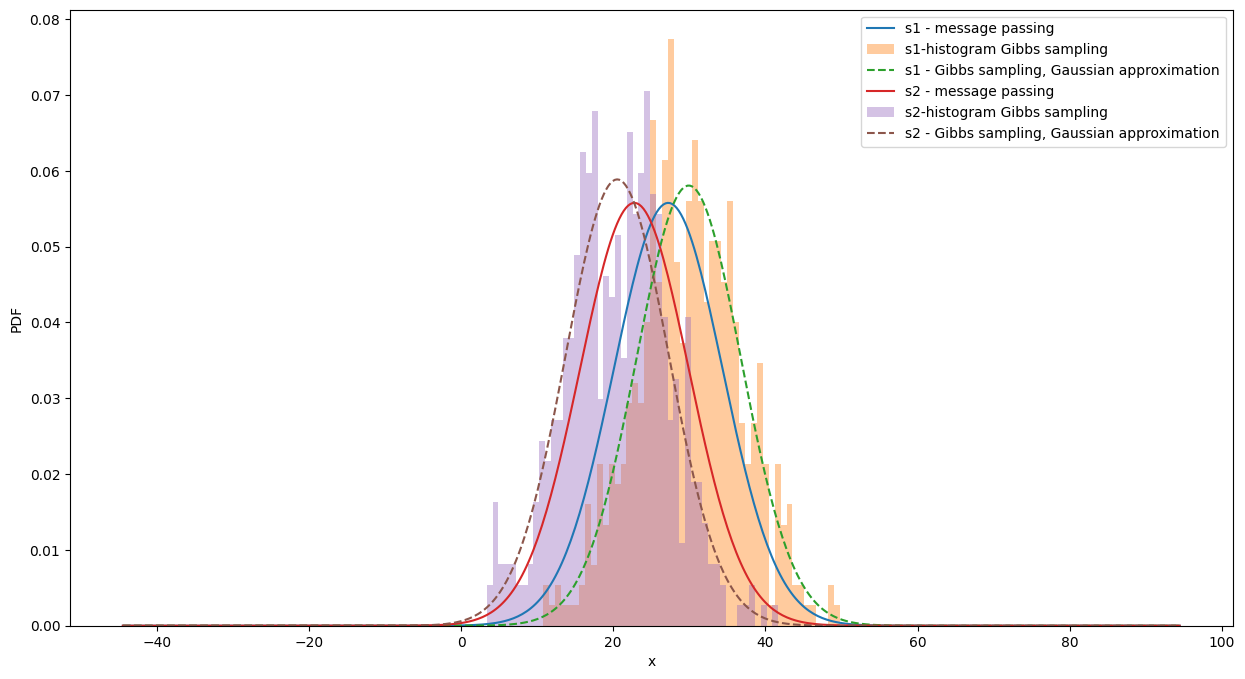

In [88]:
# plot the posteriors computed with message passing, the histogram and the Gaussian approximation from Gibbs sampling for player 1
plt.figure(figsize=(15, 8))
plt.plot(x,s1_pdf,'-',label = 's1 - message passing')
plt.hist(s1_samples, label='s1-histogram Gibbs sampling',density = True,bins=50, alpha = 0.4)
plt.plot(x,s1_gibbs_pdf,'--',label = "s1 - Gibbs sampling, Gaussian approximation")


# plot the posteriors computed with message passing, the histogram and the Gaussian approximation from Gibbs sampling for player 1
plt.plot(x,s2_pdf,'-',label = 's2 - message passing')
plt.hist(s2_samples, label='s2-histogram Gibbs sampling',density = True,bins=50, alpha = 0.4)
plt.plot(x,s2_gibbs_pdf,'--',label = "s2 - Gibbs sampling, Gaussian approximation")

plt.xlabel('x')
plt.ylabel('PDF')
plt.legend()
plt.show()

# Question 9: Our own data

### Import the data of the matches played during Euro24

In [105]:
df_comp = sb.competitions()
df_euro = df_comp[df_comp['competition_name'] == "UEFA Euro"]
matches = sb.matches(competition_id=55, season_id=282)
matches.head()

/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
0,3942819,2024-07-10,22:00:00.000,Europe - UEFA Euro,2024,Netherlands,England,1,2,available,...,2024-07-15T07:57:36.684453,6,Semi-finals,Signal-Iduna-Park,Felix Zwayer,Ronald Koeman,Gareth Southgate,1.1.0,2,2
1,3943043,2024-07-14,22:00:00.000,Europe - UEFA Euro,2024,Spain,England,2,1,available,...,2024-07-15T15:52:24.778809,7,Final,Olympiastadion Berlin,François Letexier,Luis de la Fuente Castillo,Gareth Southgate,1.1.0,2,2
2,3942752,2024-07-09,22:00:00.000,Europe - UEFA Euro,2024,Spain,France,2,1,available,...,2024-07-10T13:01:26.597509,6,Semi-finals,Allianz Arena,Slavko Vinčić,Luis de la Fuente Castillo,Didier Deschamps,1.1.0,2,2
3,3942382,2024-07-06,22:00:00.000,Europe - UEFA Euro,2024,Netherlands,Turkey,2,1,available,...,2024-07-10T06:56:35.146850,5,Quarter-finals,Olympiastadion Berlin,Clément Turpin,Ronald Koeman,Vincenzo Montella,1.1.0,2,2
4,3942349,2024-07-05,22:00:00.000,Europe - UEFA Euro,2024,Portugal,France,0,0,available,...,2024-07-12T02:00:16.871522,5,Quarter-finals,Volksparkstadion,Michael Oliver,Roberto Martínez Montoliú,Didier Deschamps,1.1.0,2,2


### Lets process the data so that only the date, time, team names, and scores are organized in a separate table

In [106]:
# Select and rename relevant columns
data = matches[['home_team', 'away_team', 'home_score', 'away_score']]
data.rename(columns={
    'home_team': 'team1',
    'away_team': 'team2',
    'home_score': 'score1',
    'away_score': 'score2'
}, inplace=True)

data.head()


<ipython-input-106-0ea5851878b4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename(columns={


,team1,team2,score1,score2
0,Netherlands,England,1,2
1,Spain,England,2,1
2,Spain,France,2,1
3,Netherlands,Turkey,2,1
4,Portugal,France,0,0


In [107]:
# Check for missing values
print(data.isnull().sum())

# Drop rows with missing values if any
data.dropna(inplace=True)

team1     0
team2     0
score1    0
score2    0
dtype: int64


<ipython-input-107-c48e39954f67>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


In [108]:
# Ensure scores are integers
data['score1'] = data['score1'].astype(int)
data['score2'] = data['score2'].astype(int)

<ipython-input-108-b8aa446ef0c2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['score1'] = data['score1'].astype(int)
<ipython-input-108-b8aa446ef0c2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['score2'] = data['score2'].astype(int)


In [109]:
# Create a list of unique teams
teams = pd.unique(data[['team1', 'team2']].values.ravel())
print("Teams involved:", teams)

Teams involved: ['Netherlands' 'England' 'Spain' 'France' 'Turkey' 'Portugal' 'Austria'
 'Denmark' 'Switzerland' 'Germany' 'Ukraine' 'Belgium' 'Czech Republic'
 'Romania' 'Slovenia' 'Georgia' 'Slovakia' 'Serbia' 'Albania' 'Italy'
 'Scotland' 'Hungary' 'Croatia' 'Poland']


In [94]:
# Initialize TrueSkill environment with zero draw probability
env = trueskill.TrueSkill(draw_probability=0)

# Dictionary to store ratings for each team
ratings = {}

In [110]:
# Initialize each team's rating
for team in teams:
    ratings[team] = env.create_rating()

ratings # Each team starts with equal rating

{'Netherlands': trueskill.Rating(mu=25.000, sigma=8.333),
 'England': trueskill.Rating(mu=25.000, sigma=8.333),
 'Spain': trueskill.Rating(mu=25.000, sigma=8.333),
 'France': trueskill.Rating(mu=25.000, sigma=8.333),
 'Turkey': trueskill.Rating(mu=25.000, sigma=8.333),
 'Portugal': trueskill.Rating(mu=25.000, sigma=8.333),
 'Austria': trueskill.Rating(mu=25.000, sigma=8.333),
 'Denmark': trueskill.Rating(mu=25.000, sigma=8.333),
 'Switzerland': trueskill.Rating(mu=25.000, sigma=8.333),
 'Germany': trueskill.Rating(mu=25.000, sigma=8.333),
 'Ukraine': trueskill.Rating(mu=25.000, sigma=8.333),
 'Belgium': trueskill.Rating(mu=25.000, sigma=8.333),
 'Czech Republic': trueskill.Rating(mu=25.000, sigma=8.333),
 'Romania': trueskill.Rating(mu=25.000, sigma=8.333),
 'Slovenia': trueskill.Rating(mu=25.000, sigma=8.333),
 'Georgia': trueskill.Rating(mu=25.000, sigma=8.333),
 'Slovakia': trueskill.Rating(mu=25.000, sigma=8.333),
 'Serbia': trueskill.Rating(mu=25.000, sigma=8.333),
 'Albania': tru

### Monte-Carlo Simulation

In [111]:
def monte_carlo_win_probability(team1_rating, team2_rating, num_simulations=10000):
    """
    Estimates the probability that team1 wins against team2 using Monte Carlo simulation.

    Parameters:
    - team1_rating: TrueSkill rating object for team1.
    - team2_rating: TrueSkill rating object for team2.
    - num_simulations: Number of simulations to run.

    Returns:
    - Probability that team1 wins.
    """
    team1_wins = 0

    # Extract mu and sigma for both teams
    mu1, sigma1 = team1_rating.mu, team1_rating.sigma
    mu2, sigma2 = team2_rating.mu, team2_rating.sigma

    for _ in range(num_simulations):
        # Sample performance from normal distributions
        perf1 = np.random.normal(mu1, sigma1)
        perf2 = np.random.normal(mu2, sigma2)

        # Increment team1_wins if team1's performance is higher
        if perf1 > perf2:
            team1_wins += 1

    # Calculate win probability
    win_probability = team1_wins / num_simulations

    return win_probability


In [112]:
# Lists to store results for analysis
predictions = []
actual_results = []

# Iterate over each match
for index, row in data.iterrows():
    # Extract teams and scores
    team1 = row['team1']
    team2 = row['team2']
    score1 = row['score1']
    score2 = row['score2']

    # Get current ratings
    team1_rating = ratings[team1]
    team2_rating = ratings[team2]

    # Step 1: Predict the outcome using Monte Carlo simulation
    win_prob = monte_carlo_win_probability(team1_rating, team2_rating)

    # Make a deterministic prediction based on win probability
    if win_prob > 0.5:
        prediction = +1  # Predict team1 wins
    else:
        prediction = -1  # Predict team2 wins

    # Append prediction
    predictions.append(prediction)

    # Step 2: Determine the actual outcome
    if score1 > score2:
        actual_result = +1  # Team 1 won
    elif score1 < score2:
        actual_result = -1  # Team 2 won
    else:
        # Match was a draw
        actual_result = 0   # We will exclude this match from analysis


    actual_results.append(actual_result)

    # Step 3: Update the TrueSkill ratings with the actual match result
    if actual_result == +1:
        # Team 1 won
        ratings[team1], ratings[team2] = env.rate_1vs1(team1_rating, team2_rating)
    elif actual_result == -1:
        # Team 2 won
        ratings[team2], ratings[team1] = env.rate_1vs1(team2_rating, team1_rating)


# Convert to numpy arrays
predictions = np.array(predictions)
actual_results = np.array(actual_results)

# Exclude matches that ended in a draw from accuracy calculation
non_draw_indices = actual_results != 0

# Calculate accuracy
accuracy = np.mean(predictions[non_draw_indices] == actual_results[non_draw_indices])

print(f'Prediction Accuracy (excluding draws): {accuracy * 100:.2f}%')


Prediction Accuracy (excluding draws): 55.88%


### Gibbs Sampling

In [116]:
# Initialize parameters
mu_1 = 25
sigma_1 =25/3
mu_2 = 25
sigma_2 = 25/3
sigma_t = 25/3
initial_mean_skill = 25.0  # Initial mean skill for each team
initial_variance = (25.0 / 3)**2  # Initial variance for each team's skill
sigma_t = 1.0  # Standard deviation for match outcomes

# Initialize skills for each team
teams = set(data['team1']).union(set(data['team2']))
skills = {team: [initial_mean_skill, np.sqrt(initial_variance)] for team in teams}
skills

{'Poland': [25.0, 8.333333333333334],
 'Albania': [25.0, 8.333333333333334],
 'England': [25.0, 8.333333333333334],
 'Croatia': [25.0, 8.333333333333334],
 'Romania': [25.0, 8.333333333333334],
 'Netherlands': [25.0, 8.333333333333334],
 'Switzerland': [25.0, 8.333333333333334],
 'Czech Republic': [25.0, 8.333333333333334],
 'Germany': [25.0, 8.333333333333334],
 'Georgia': [25.0, 8.333333333333334],
 'Scotland': [25.0, 8.333333333333334],
 'Turkey': [25.0, 8.333333333333334],
 'France': [25.0, 8.333333333333334],
 'Serbia': [25.0, 8.333333333333334],
 'Italy': [25.0, 8.333333333333334],
 'Portugal': [25.0, 8.333333333333334],
 'Spain': [25.0, 8.333333333333334],
 'Ukraine': [25.0, 8.333333333333334],
 'Slovakia': [25.0, 8.333333333333334],
 'Austria': [25.0, 8.333333333333334],
 'Denmark': [25.0, 8.333333333333334],
 'Slovenia': [25.0, 8.333333333333334],
 'Hungary': [25.0, 8.333333333333334],
 'Belgium': [25.0, 8.333333333333334]}

In [117]:
# Function to sample t given s1 and s2
def sample_t(s1, s2, sigma_t):
    return np.random.normal(s1 - s2, sigma_t)

# Truncated Gaussian helper function for sampling with truncation
def truncated_gaussian(mean, std, lower_bound, upper_bound):
    a, b = (lower_bound - mean) / std, (upper_bound - mean) / std
    return truncnorm.rvs(a, b, loc=mean, scale=std)

# Function to sample s = [s1, s2] given t using truncated normal
def sample_s_given_t(t, mu_1, mu_2, sigma_1, sigma_2, sigma_t):
    variance_s1 = sigma_1**2
    variance_s2 = sigma_2**2

    # Precompute components for efficiency
    A = np.array([[1, -1]])
    Sigma_s_inv = np.array([[1 / variance_s1, 0], [0, 1 / variance_s2]])

    inv_sigma_t = 1 / (sigma_t**2)
    cov_s_given_t = np.linalg.inv(A.T @ A * inv_sigma_t + Sigma_s_inv)

    # Ensure the mean vector is one-dimensional
    mean_s_given_t = cov_s_given_t @ (A.T * inv_sigma_t * t + Sigma_s_inv @ np.array([[mu_1], [mu_2]]))
    mean_s_given_t = mean_s_given_t.flatten()

    # Draw samples from the truncated normal distribution for s1 > s2
    s_diff_mean = mean_s_given_t[0] - mean_s_given_t[1]
    s_diff_std = np.sqrt(cov_s_given_t[0, 0] + cov_s_given_t[1, 1] - 2 * cov_s_given_t[0, 1])

    # Truncate so that s1 - s2 > 0
    s_diff = truncated_gaussian(s_diff_mean, s_diff_std, 0, np.inf)

    # Sample s2 and compute s1 = s2 + s_diff
    s2 = np.random.normal(mean_s_given_t[1], np.sqrt(cov_s_given_t[1, 1]))
    s1 = s2 + s_diff

    return [s1, s2]

# Gibbs Sampling with Burn-in
def gibbs_sampling(num_samples, burn_in, initial_s1, initial_s2):
    s1_samples = np.zeros(num_samples)
    s2_samples = np.zeros(num_samples)

    # Initialize first samples
    s1_samples[0] = initial_s1[0]
    s2_samples[0] = initial_s2[0]

    for i in range(1, num_samples):
        s1_current = s1_samples[i - 1]
        s2_current = s2_samples[i - 1]

        t_new = sample_t(s1_current, s2_current, sigma_t)

        # Sample s given t using truncated Gaussian
        s_new = sample_s_given_t(t_new, initial_s1[0], initial_s2[0], initial_s1[1], initial_s2[1], sigma_t)
        s1_samples[i] = s_new[0]
        s2_samples[i] = s_new[1]

    return s1_samples[burn_in:], s2_samples[burn_in:]

# Parameters for Gibbs sampling
num_samples = 10000
burn_in = 500  # Number of samples to discard


for idx, row in data.iterrows():
    team1, team2 = row['team1'], row['team2']
    score1, score2 = row['score1'], row['score2']

    # Skip draws
    if score1 == score2:
        continue

    # Get initial skills for teams
    s1_initial = skills[team1]
    s2_initial = skills[team2]

    # Perform Gibbs sampling
    if score1 > score2:
        s1_samples, s2_samples = gibbs_sampling(num_samples, burn_in, s1_initial, s2_initial)
    else:
        s2_samples, s1_samples = gibbs_sampling(num_samples, burn_in, s2_initial, s1_initial)

    skills[team1] = [np.mean(s1_samples), np.std(s1_samples)]
    skills[team2] = [np.mean(s2_samples), np.std(s2_samples)]

    # Calculating cumulative means
    s1_cumulative_mean = np.cumsum(s1_samples) / np.arange(1, len(s1_samples) + 1)
    s2_cumulative_mean = np.cumsum(s2_samples) / np.arange(1, len(s2_samples) + 1)

    print(f"Initial skills for {team1}: Mean = {s1_initial[0]}, Standard Deviation  = {s1_initial[1]}")
    print(f"Initial skills for {team2}: Mean = {s2_initial[0]},  Standard Deviation = {s2_initial[1]}")
    print(f"Updated skills for {team1}: Mean = {skills[team1][0]},  Standard Deviation = {skills[team1][1]}")
    print(f"Updated skills for {team2}: Mean = {skills[team2][0]},  Standard Deviation = {skills[team2][1]}")
    print()




Initial skills for Netherlands: Mean = 25.0, Standard Deviation  = 8.333333333333334
Initial skills for England: Mean = 25.0,  Standard Deviation = 8.333333333333334
Updated skills for Netherlands: Mean = 19.80713581451753,  Standard Deviation = 7.111857775802601
Updated skills for England: Mean = 30.177227151675996,  Standard Deviation = 7.104601996935198

Initial skills for Spain: Mean = 25.0, Standard Deviation  = 8.333333333333334
Initial skills for England: Mean = 30.177227151675996,  Standard Deviation = 7.104601996935198
Updated skills for Spain: Mean = 32.28430345791628,  Standard Deviation = 6.291911945942322
Updated skills for England: Mean = 24.859443849497072,  Standard Deviation = 5.96799423246632

Initial skills for Spain: Mean = 32.28430345791628, Standard Deviation  = 6.291911945942322
Initial skills for France: Mean = 25.0,  Standard Deviation = 8.333333333333334
Updated skills for Spain: Mean = 34.410236174374994,  Standard Deviation = 5.929804558286715
Updated skills

### Truncated Normal

In [119]:
# Initialize parameters
initial_mean_skill = 25.0  # Initial mean skill for each team
initial_variance = 25.0 / 3  # Initial variance for each team's skill
sigma_t = 1.0  # Standard deviation for match outcomes

# Initialize skills for each team
teams = set(data['team1']).union(set(data['team2']))
skills = {team: [initial_mean_skill, np.sqrt(initial_variance)] for team in teams}

# Function to sample t given s1 and s2
def sample_t(s1, s2, sigma_t):
    return np.random.normal(s1 - s2, sigma_t)

# Truncated Gaussian helper function for sampling with truncation
def truncated_gaussian(mean, std, lower_bound, upper_bound):
    a, b = (lower_bound - mean) / std, (upper_bound - mean) / std
    return truncnorm.rvs(a, b, loc=mean, scale=std)

# Function to sample s = [s1, s2] given t using truncated normal
def sample_s_given_t(t, mu_1, mu_2, sigma_1, sigma_2, sigma_t):
    variance_s1 = sigma_1**2
    variance_s2 = sigma_2**2

    # Precompute components for efficiency
    A = np.array([[1, -1]])
    Sigma_s_inv = np.array([[1 / variance_s1, 0], [0, 1 / variance_s2]])

    inv_sigma_t = 1 / (sigma_t**2)
    cov_s_given_t = np.linalg.inv(A.T @ A * inv_sigma_t + Sigma_s_inv)

    # Ensure the mean vector is one-dimensional
    mean_s_given_t = cov_s_given_t @ (A.T * inv_sigma_t * t + Sigma_s_inv @ np.array([[mu_1], [mu_2]]))
    mean_s_given_t = mean_s_given_t.flatten()

    # Draw samples from the truncated normal distribution for s1 > s2
    s_diff_mean = mean_s_given_t[0] - mean_s_given_t[1]
    s_diff_std = np.sqrt(cov_s_given_t[0, 0] + cov_s_given_t[1, 1] - 2 * cov_s_given_t[0, 1])

    # Truncate so that s1 - s2 > 0
    s_diff = truncated_gaussian(s_diff_mean, s_diff_std, 0, np.inf)

    # Sample s2 and compute s1 = s2 + s_diff
    s2 = np.random.normal(mean_s_given_t[1], np.sqrt(cov_s_given_t[1, 1]))
    s1 = s2 + s_diff

    return [s1, s2]

# Gibbs Sampling with Burn-in
def gibbs_sampling(num_samples, burn_in, initial_s1, initial_s2):
    s1_samples = np.zeros(num_samples)
    s2_samples = np.zeros(num_samples)

    # Initialize first samples
    s1_samples[0] = initial_s1[0]
    s2_samples[0] = initial_s2[0]

    for i in range(1, num_samples):
        s1_current = s1_samples[i - 1]
        s2_current = s2_samples[i - 1]

        t_new = sample_t(s1_current, s2_current, sigma_t)

        # Sample s given t using truncated Gaussian
        s_new = sample_s_given_t(t_new, initial_s1[0], initial_s2[0], initial_s1[1], initial_s2[1], sigma_t)
        s1_samples[i] = s_new[0]
        s2_samples[i] = s_new[1]

    return s1_samples[burn_in:], s2_samples[burn_in:]

# Parameters for Gibbs sampling
num_samples = 10000
burn_in = 500  # Number of samples to discard


for idx, row in data.iterrows():
    team1, team2 = row['team1'], row['team2']
    score1, score2 = row['score1'], row['score2']

    # Skip draws
    if score1 == score2:
        continue

    # Get initial skills for teams
    s1_initial = skills[team1]
    s2_initial = skills[team2]

    # Perform Gibbs sampling
    if score1 > score2:
        s1_samples, s2_samples = gibbs_sampling(num_samples, burn_in, s1_initial, s2_initial)
    else:
        s2_samples, s1_samples = gibbs_sampling(num_samples, burn_in, s2_initial, s1_initial)

    skills[team1] = [np.mean(s1_samples), np.std(s1_samples)]
    skills[team2] = [np.mean(s2_samples), np.std(s2_samples)]

skills

{'Poland': [22.472179622859546, 1.9221430439428175],
 'Albania': [22.753717245463697, 2.136821868000401],
 'England': [27.1389619501387, 2.174603081757007],
 'Croatia': [24.643837278354223, 2.6153804742181195],
 'Romania': [23.58772801168937, 1.5823627348643294],
 'Netherlands': [26.42234134623132, 2.0464893881805017],
 'Switzerland': [27.819673765217786, 2.219892510427568],
 'Czech Republic': [22.147504706996127, 2.074824295643328],
 'Germany': [27.873054813603773, 2.1830512419956194],
 'Georgia': [25.200656990032467, 2.1062917477383016],
 'Scotland': [23.13245696361369, 2.244621050107626],
 'Turkey': [25.040520793152755, 1.6789707988124134],
 'France': [27.014277759651065, 1.9490976629155268],
 'Serbia': [23.679375817321215, 2.425611921076998],
 'Italy': [25.127003841804715, 2.153032170813665],
 'Portugal': [26.61037169177496, 1.9174844520742746],
 'Spain': [30.199475962008258, 2.518946380362103],
 'Ukraine': [24.219341515503174, 1.879491568471854],
 'Slovakia': [23.7916907779977, 1.

In [120]:
# Sort the dictionary by the first element of each value list
sorted_data = dict(sorted(skills.items(), key=lambda x: x[1][0], reverse=True))

# Print the sorted dictionary
for team, values in sorted_data.items():
    print(f"{team}: {round(values[0],2)} , {round(values[1],2)}")

Spain: 30.2 , 2.52
Germany: 27.87 , 2.18
Switzerland: 27.82 , 2.22
England: 27.14 , 2.17
France: 27.01 , 1.95
Portugal: 26.61 , 1.92
Netherlands: 26.42 , 2.05
Georgia: 25.2 , 2.11
Italy: 25.13 , 2.15
Turkey: 25.04 , 1.68
Austria: 25.03 , 1.79
Slovenia: 25.0 , 2.89
Belgium: 24.87 , 1.64
Croatia: 24.64 , 2.62
Hungary: 24.51 , 1.9
Ukraine: 24.22 , 1.88
Slovakia: 23.79 , 1.91
Serbia: 23.68 , 2.43
Romania: 23.59 , 1.58
Denmark: 23.17 , 2.38
Scotland: 23.13 , 2.24
Albania: 22.75 , 2.14
Poland: 22.47 , 1.92
Czech Republic: 22.15 , 2.07


# Question 10: Open-ended project extension

In [102]:
# Initialize a dictionary to store the points for each team
points = {}

# Function to update points for a match
def update_points(team1, team2, score1, score2):
    if team1 not in points:
        points[team1] = 0
    if team2 not in points:
        points[team2] = 0

    # Determine points based on the result
    if score1 > score2:
        points[team1] += 3  # team1 wins
    elif score2 > score1:
        points[team2] += 3  # team2 wins
    else:
        points[team1] += 1  # draw
        points[team2] += 1  # draw

# Function to check if a team has become the champion
def check_for_champion(total_matches_left):
    max_points = max(points.values())  # current max points
    leaders = [team for team, pts in points.items() if pts == max_points]  # teams with max points

    # The team with the most points should have a lead that can't be overcome
    second_max_points = max([pts for team, pts in points.items() if team not in leaders], default=0)

    if len(leaders) == 1:
        leader = leaders[0]
        remaining_points_possible = total_matches_left * 3
        if max_points > second_max_points + remaining_points_possible:
            print(f"The champion is {leader} with {max_points} points and {total_matches_left} matches left!")
            return True
    return False

# Iterate through the dataset, row by row
for idx, row in data.iterrows():
    team1 = row['team1']
    team2 = row['team2']
    score1 = row['score1']
    score2 = row['score2']

    # Update points for the current match
    update_points(team1, team2, score1, score2)

    # Calculate how many matches are left
    total_matches_left = len(data) - (idx + 1)

    # Check if any team has become the champion
    if check_for_champion(total_matches_left):
        break  # End the loop once a champion is found


The champion is Spain with 21 points and 2 matches left!


In [103]:
# Sample data for Serie A matches (replace this with the full dataset)
data = pd.read_csv('SerieA.csv')

# Whether to shuffle the data or not
shuffle = False

if shuffle:
    # Shuffle the order of the DataFrame
    shuffled_data = data.sample(frac=1, random_state=1).reset_index(drop=True)
    data = shuffled_data

# Initialize parameters
initial_mean_skill = 25.0  # Initial mean skill for each team
initial_variance = 25.0 / 3  # Initial variance for each team's skill
sigma_t = 1.0  # Standard deviation for match outcomes

# Initialize skills for each team
teams = set(data['team1']).union(set(data['team2']))
skills = {team: [initial_mean_skill, np.sqrt(initial_variance)] for team in teams}

# Track Juventus' last three matches
juventus_matches = data[(data['team1'] == 'Juventus') | (data['team2'] == 'Juventus')]
juventus_last_three = juventus_matches.tail(3).index.tolist()

# Parameters for Gibbs sampling
num_samples = 10000
burn_in = 500  # Number of samples to discard


# Loop through each match in the dataset
for idx, row in data.iterrows():
    team1, team2 = row['team1'], row['team2']
    score1, score2 = row['score1'], row['score2']

    # Skip Juventus' last three matches (as they were champions already)
    if idx in juventus_last_three:
        print(f"Skipping Juventus match at index {idx} (Champion)")
        continue

    # Skip draws
    if score1 == score2:
        continue

    # Get initial skills for teams
    s1_initial = skills[team1]
    s2_initial = skills[team2]

    # Perform Gibbs sampling based on the outcome
    if score1 > score2:
        s1_samples, s2_samples = gibbs_sampling(num_samples, burn_in, s1_initial, s2_initial)
    else:
        s2_samples, s1_samples = gibbs_sampling(num_samples, burn_in, s2_initial, s1_initial)

    # Update skills with the mean and variance from the samples
    skills[team1] = [np.mean(s1_samples), np.std(s1_samples)]
    skills[team2] = [np.mean(s2_samples), np.std(s2_samples)]

    # Optionally: calculate cumulative means (for tracking skill evolution over time)
    s1_cumulative_mean = np.cumsum(s1_samples) / np.arange(1, len(s1_samples) + 1)
    s2_cumulative_mean = np.cumsum(s2_samples) / np.arange(1, len(s2_samples) + 1)

    # Output skill updates for tracking purposes
    print(f"Match {idx}: {team1} vs {team2}")
    print(f"Initial skills for {team1}: Mean = {s1_initial[0]}, Variance = {s1_initial[1]**2}")
    print(f"Initial skills for {team2}: Mean = {s2_initial[0]}, Variance = {s2_initial[1]**2}")
    print(f"Updated skills for {team1}: Mean = {skills[team1][0]}, Variance = {skills[team1][1]**2}")
    print(f"Updated skills for {team2}: Mean = {skills[team2][0]}, Variance = {skills[team2][1]**2}")
    print()


Match 0: Chievo vs Juventus
Initial skills for Chievo: Mean = 25.0, Variance = 8.333333333333336
Initial skills for Juventus: Mean = 25.0, Variance = 8.333333333333336
Updated skills for Chievo: Mean = 23.481836826286617, Variance = 5.955815677877722
Updated skills for Juventus: Mean = 26.726406801562167, Variance = 6.482095329464581

Match 1: Lazio vs Napoli
Initial skills for Lazio: Mean = 25.0, Variance = 8.333333333333336
Initial skills for Napoli: Mean = 25.0, Variance = 8.333333333333336
Updated skills for Lazio: Mean = 23.549349949806707, Variance = 5.993454143053513
Updated skills for Napoli: Mean = 26.644713999495046, Variance = 6.23616732133198

Match 2: Torino vs Roma
Initial skills for Torino: Mean = 25.0, Variance = 8.333333333333336
Initial skills for Roma: Mean = 25.0, Variance = 8.333333333333336
Updated skills for Torino: Mean = 23.507439033244882, Variance = 6.063049581959189
Updated skills for Roma: Mean = 26.719739125380343, Variance = 6.3326066444984574

Match 3: S

In [104]:
# Sort the dictionary by the first element of each value list
sorted_data = dict(sorted(skills.items(), key=lambda x: x[1][0], reverse=True))

# Print the sorted dictionary
for team, values in sorted_data.items():
    print(f"{team}: {round(values[0],2)} , {round(values[1],2)}")

Atalanta: 30.29 , 1.66
Bologna: 30.07 , 1.17
Inter: 29.75 , 1.16
Roma: 29.71 , 1.35
Milan: 29.69 , 1.32
Udinese: 29.22 , 1.15
Napoli: 29.21 , 1.13
Torino: 29.18 , 1.09
Empoli: 28.61 , 1.07
Juventus: 28.15 , 1.24
Lazio: 27.98 , 0.92
Spal: 27.79 , 0.99
Cagliari: 27.33 , 0.87
Chievo: 26.77 , 0.91
Sassuolo: 26.41 , 0.98
Frosinone: 26.39 , 0.85
Sampdoria: 26.33 , 0.89
Parma: 26.27 , 0.94
Genoa: 26.16 , 0.94
Fiorentina: 25.2 , 0.79
